## 9-11 프로젝트: 네이버 영화리뷰 감성분석 도전하기

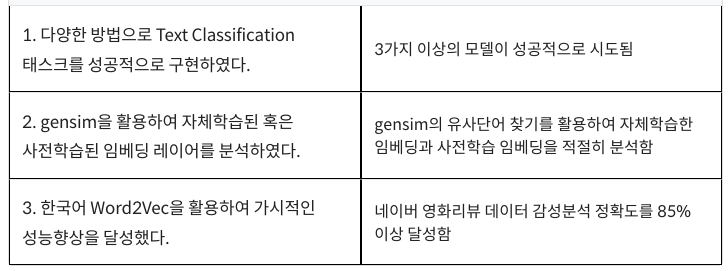

### 1) 데이터 준비와 확인

In [435]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 09/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 09/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2)데이터로더 구성

- 데이터의 중복 제거
- NaN 결측체 제거
- 한국어 토크나이저로 토큰화
- 불용어 제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴



In [436]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 256 kB in 2s (149 kB/s)
Reading p

In [3]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-05-29 00:49:35--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-05-29 00:49:35--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdf291bc9e91607f2763d7de802.dl.dropboxusercontent.com/cd/0/get/BmLovRlHDJ9GgZrBY5YExKR0dzbYPukwWWXmS-R4zFaeyWPTzyJn08eHoTsi20NuF84bq2Ws5cro3rW7Y2VnPVbFuCf9ZHyaIYBtbCAxxZCDaIeWoMIvktmArVZXgBh24KArtqUZmyRSZWFhe_1-pfK8rCiv3QpOC9XfHrD82qc_vnh1cTEBgrfK6aR8zGwcky8/file?dl=1# [following]
--2022-05-29 00:49:35--  https://ucdf291bc9e91607f2763d7de802.dl.dropboxusercontent.com/cd/0/g

In [437]:
import pandas
import konlpy
import gensim

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

import re


In [438]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [439]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [440]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [441]:
# 데이터셋 내 문장 길이 분포

total_data = X_train + X_test
num = np.array([len(words) for words in total_data])

print('문장길이 평균 : ', np.mean(num))
print('문장길이 최대 : ', np.max(num))
print('문장길이 표준편차 : ', np.std(num))
print('평균 + 표준편차*2.5 : ', np.mean(num)+2.5*np.std(num))
print('평균 + 표준편차*3: ', np.mean(num)+3*np.std(num))
print('평균 + 표준편차*4: ', np.mean(num)+4*np.std(num))


문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
평균 + 표준편차*2.5 :  48.078329889278635
평균 + 표준편차*3:  54.50011548482465
평균 + 표준편차*4:  67.34368667591664


In [442]:
# 적절한 최대 문장 길이 지정 

maxlen = 48
print('전체 문장의 {}% : maxlen 이하'.format(np.sum(num < maxlen) / len(num)))

전체 문장의 0.9521754488351021% : maxlen 이하


In [443]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [354]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  32,
        74, 919,   4,   4,  39, 228,  20,  33, 748], dtype=int32)

In [355]:
print(X_train.shape)
print(X_test.shape)

(146182, 48)
(49157, 48)


### 4) 모델 구성 및 validation set 구성

- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.


In [444]:
# validation set 분리

from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(X_train, y_train,
                                                  test_size=0.2,
                                                  shuffle=False, 
                                                  random_state=9082)

In [357]:
print(val_X.shape)
print(val_y.shape)
print(train_X.shape)
print(train_y.shape)

(29237, 48)
(29237,)
(116945, 48)
(116945,)


In [358]:
train_X[1000] == X_train[1000]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

### 5) 모델 훈련 개시

  5-1) LSTM 모델

In [359]:
vocab_size = 10000  
word_vector_dim = 16 

model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(128))                        #  RNN에서 가장 널리 사용하는 LSTM 레이어 사용
model1.add(keras.layers.Dense(16, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1 dim 
model1.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, None, 16)          160000    
                                                                 
 lstm_15 (LSTM)              (None, 128)               74240     
                                                                 
 dense_48 (Dense)            (None, 16)                2064      
                                                                 
 dense_49 (Dense)            (None, 1)                 17        
                                                                 
Total params: 236,321
Trainable params: 236,321
Non-trainable params: 0
_________________________________________________________________


In [360]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model1_history = model1.fit(train_X,
                            train_y,
                            epochs=10, 
                            batch_size = 256, 
                            validation_data = (val_X, val_y), 
                            verbose = 1)

Epoch 1/10
457/457 [==============================] - 6s 10ms/step - loss: 0.4163 - accuracy: 0.8072 - val_loss: 0.3550 - val_accuracy: 0.8474
Epoch 2/10
457/457 [==============================] - 4s 9ms/step - loss: 0.3304 - accuracy: 0.8595 - val_loss: 0.3515 - val_accuracy: 0.8490
Epoch 3/10
457/457 [==============================] - 4s 8ms/step - loss: 0.3130 - accuracy: 0.8685 - val_loss: 0.3470 - val_accuracy: 0.8502
Epoch 4/10
457/457 [==============================] - 4s 9ms/step - loss: 0.2956 - accuracy: 0.8770 - val_loss: 0.3378 - val_accuracy: 0.8536
Epoch 5/10
457/457 [==============================] - 4s 8ms/step - loss: 0.2754 - accuracy: 0.8848 - val_loss: 0.3312 - val_accuracy: 0.8572
Epoch 6/10
457/457 [==============================] - 4s 9ms/step - loss: 0.2529 - accuracy: 0.8957 - val_loss: 0.3361 - val_accuracy: 0.8579
Epoch 7/10
457/457 [==============================] - 4s 8ms/step - loss: 0.2328 - accuracy: 0.9036 - val_loss: 0.3632 - val_accuracy: 0.8584
Epoch

In [361]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 4s - loss: 0.4332 - accuracy: 0.8477 - 4s/epoch - 3ms/step
[0.4331691265106201, 0.8477327823638916]


In [362]:
history_dict1 = model1_history.history
print(history_dict1.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 6) Loss, Accuracy 그래프 시각화

  6-1) LSTM 모델

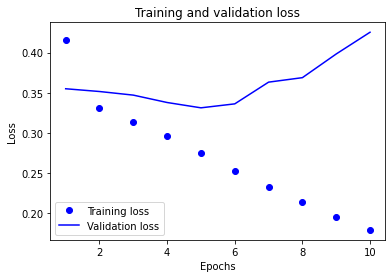

In [363]:
import matplotlib.pyplot as plt

acc1 = history_dict1['accuracy']
val_acc1 = history_dict1['val_accuracy']
loss1 = history_dict1['loss']
val_loss1 = history_dict1['val_loss']

epochs = range(1, len(acc1) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss1, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

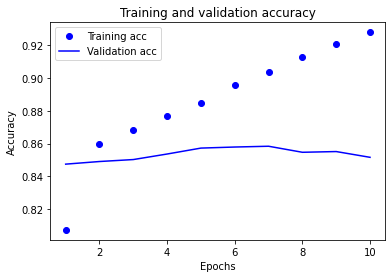

In [364]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc1, 'bo', label='Training acc')
plt.plot(epochs, val_acc1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석


  7-1) LSTM 모델

In [365]:
# 단어의 특성을 저차원 벡터값으로 표현할 수 있는 워드 임베딩(word embedding) 기법
embedding_layer = model1.layers[0]           
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [366]:
import os
from gensim import models     # gensim : 워드벡터를 다루는데 유용한 패키지

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path1 = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 09/word2vec_model1.txt'
f = open(word2vec_file_path1, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [367]:
# 임베딩 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path1, binary=False)
vector = word_vectors['느낌']
vector

array([-0.03299435,  0.04983034, -0.06042607,  0.01529943,  0.05151491,
        0.00233085,  0.02528548, -0.03595647,  0.02151796,  0.0077857 ,
       -0.03128401,  0.03159267,  0.04352734,  0.05018805,  0.02253535,
        0.02236456], dtype=float32)

In [368]:
# 가장 유사한 단어와 유사도 확인
word_vectors.similar_by_word("느낌")

[('로맨스', 0.7795766592025757),
 ('그려', 0.7381312847137451),
 ('우', 0.7284618616104126),
 ('간', 0.7186295986175537),
 ('그래서', 0.7102404832839966),
 ('과학', 0.708387017250061),
 ('찾아본', 0.6761116981506348),
 ('소린지', 0.668515145778656),
 ('샹', 0.6655269861221313),
 ('출', 0.6630117297172546)]

  5-2) 1-D Convolution Neural Network (1-D CNN) 모델
  
(https://velog.io/@shoulmon/SSACAIFFEL-20210114-%EB%84%A4%EC%9D%B4%EB%B2%84-%EC%98%81%ED%99%94-%EB%A6%AC%EB%B7%B0-%EA%B0%90%EC%84%B1-%EB%B6%84%EC%84%9D%ED%95%98%EA%B8%B0-jvwzuadq)

In [369]:
vocab_size = 10000  
word_vector_dim = 32  

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, None, 32)          320000    
                                                                 
 conv1d_10 (Conv1D)          (None, None, 16)          3600      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_9 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_50 (Dense)            (None, 8)               

In [370]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model2_history = model2.fit(train_X,
                            train_y,
                            epochs=10, 
                            batch_size = 256, 
                            validation_data = (val_X, val_y), 
                            verbose = 1)

Epoch 1/10
457/457 [==============================] - 3s 6ms/step - loss: 0.4880 - accuracy: 0.7453 - val_loss: 0.3864 - val_accuracy: 0.8253
Epoch 2/10
457/457 [==============================] - 2s 5ms/step - loss: 0.3535 - accuracy: 0.8409 - val_loss: 0.3732 - val_accuracy: 0.8313
Epoch 3/10
457/457 [==============================] - 2s 5ms/step - loss: 0.3068 - accuracy: 0.8651 - val_loss: 0.3813 - val_accuracy: 0.8310
Epoch 4/10
457/457 [==============================] - 2s 5ms/step - loss: 0.2567 - accuracy: 0.8897 - val_loss: 0.4082 - val_accuracy: 0.8273
Epoch 5/10
457/457 [==============================] - 3s 6ms/step - loss: 0.2040 - accuracy: 0.9150 - val_loss: 0.4574 - val_accuracy: 0.8190
Epoch 6/10
457/457 [==============================] - 3s 7ms/step - loss: 0.1593 - accuracy: 0.9358 - val_loss: 0.5245 - val_accuracy: 0.8165
Epoch 7/10
457/457 [==============================] - 2s 5ms/step - loss: 0.1265 - accuracy: 0.9496 - val_loss: 0.6098 - val_accuracy: 0.8102
Epoch 

In [371]:
results2 = model2.evaluate(X_test,  y_test, verbose=2)
print(results2)
history_dict2 = model2_history.history
print(history_dict2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

1537/1537 - 3s - loss: 0.8794 - accuracy: 0.7980 - 3s/epoch - 2ms/step
[0.8794416785240173, 0.7979534864425659]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


  6-2) 1-D Convolution Neural Network (1-D CNN) 모델


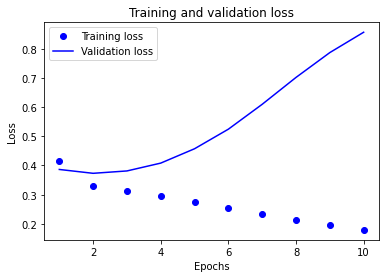

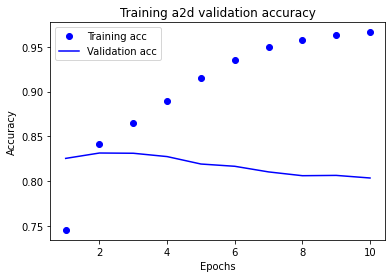

In [372]:
import matplotlib.pyplot as plt

acc2 = history_dict2['accuracy']
val_acc2 = history_dict2['val_accuracy']
loss2 = history_dict2['loss']
val_loss2 = history_dict2['val_loss']

epochs = range(1, len(acc2) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss1, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc2, 'bo', label='Training acc')
plt.plot(epochs, val_acc2, 'b', label='Validation acc')
plt.title('Training a2d validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

  7-2) 1-D Convolution Neural Network (1-D CNN) 모델


In [373]:
import os
from gensim import models     # gensim : 워드벡터를 다루는데 유용한 패키지

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path2 = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 09/word2vec_model2.txt'
f = open(word2vec_file_path2, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model2.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [374]:
# 임베딩 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path2, binary=False)
vector = word_vectors['느낌']
vector

array([-0.02161436,  0.04778099,  0.06071668,  0.00997161,  0.03590376,
       -0.13976733, -0.09934678, -0.06118592,  0.03343758,  0.06569254,
        0.08861195, -0.1107147 ,  0.05381455, -0.00700167, -0.09234511,
       -0.01342716,  0.07630628,  0.03112642, -0.13503116,  0.12965591,
        0.02493411,  0.06127975, -0.02987493,  0.16950664, -0.02131479,
       -0.21090905, -0.01299683, -0.0767094 , -0.03064468, -0.05512113,
        0.03443727,  0.07399662], dtype=float32)

In [375]:
# 가장 유사한 단어와 유사도 확인
word_vectors.similar_by_word("느낌")

[('단절', 0.6975836157798767),
 ('느껴진', 0.6009957790374756),
 ('륵', 0.5892896056175232),
 ('마이클베이', 0.5766763687133789),
 ('든', 0.5729772448539734),
 ('웹툰', 0.5568435192108154),
 ('공', 0.5559889674186707),
 ('죄다', 0.5531184673309326),
 ('방법', 0.541786789894104),
 ('리스', 0.5342166423797607)]

  5-3) GlobalMaxPooling1D 모델

  

In [376]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, None, 32)          320000    
                                                                 
 global_max_pooling1d_10 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_52 (Dense)            (None, 8)                 264       
                                                                 
 dense_53 (Dense)            (None, 1)                 9         
                                                                 
Total params: 320,273
Trainable params: 320,273
Non-trainable params: 0
_________________________________________________________________


In [377]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model3_history = model3.fit(train_X,
                            train_y,
                            epochs=10, 
                            batch_size = 256, 
                            validation_data = (val_X, val_y), 
                            verbose = 1)

Epoch 1/10
457/457 [==============================] - 2s 4ms/step - loss: 0.4855 - accuracy: 0.7845 - val_loss: 0.3644 - val_accuracy: 0.8398
Epoch 2/10
457/457 [==============================] - 2s 4ms/step - loss: 0.3284 - accuracy: 0.8601 - val_loss: 0.3464 - val_accuracy: 0.8493
Epoch 3/10
457/457 [==============================] - 2s 4ms/step - loss: 0.2879 - accuracy: 0.8802 - val_loss: 0.3455 - val_accuracy: 0.8512
Epoch 4/10
457/457 [==============================] - 2s 4ms/step - loss: 0.2583 - accuracy: 0.8944 - val_loss: 0.3539 - val_accuracy: 0.8514
Epoch 5/10
457/457 [==============================] - 2s 4ms/step - loss: 0.2330 - accuracy: 0.9066 - val_loss: 0.3640 - val_accuracy: 0.8501
Epoch 6/10
457/457 [==============================] - 2s 4ms/step - loss: 0.2102 - accuracy: 0.9186 - val_loss: 0.3799 - val_accuracy: 0.8474
Epoch 7/10
457/457 [==============================] - 2s 4ms/step - loss: 0.1892 - accuracy: 0.9281 - val_loss: 0.4001 - val_accuracy: 0.8455
Epoch 

In [378]:
results3 = model3.evaluate(X_test,  y_test, verbose=2)
print(results3)
history_dict3 = model3_history.history
print(history_dict3.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

1537/1537 - 2s - loss: 0.4954 - accuracy: 0.8296 - 2s/epoch - 2ms/step
[0.49537232518196106, 0.829627513885498]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


  6-3) GlobalMaxPooling1D 모델

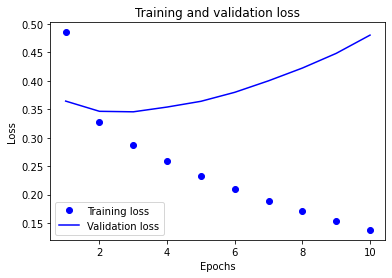

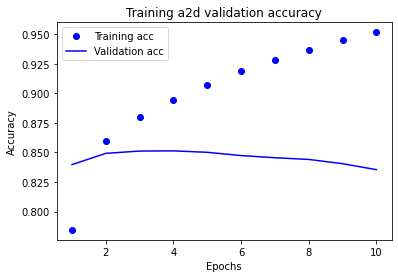

In [379]:
import matplotlib.pyplot as plt

acc3 = history_dict3['accuracy']
val_acc3 = history_dict3['val_accuracy']
loss3 = history_dict3['loss']
val_loss3 = history_dict3['val_loss']

epochs = range(1, len(acc3) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss3, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc3, 'bo', label='Training acc')
plt.plot(epochs, val_acc3, 'b', label='Validation acc')
plt.title('Training a2d validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

  7-3) GlobalMaxPooling1D 모델

In [380]:
import os
from gensim import models     # gensim : 워드벡터를 다루는데 유용한 패키지

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path3 = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 09/word2vec_model3.txt'
f = open(word2vec_file_path3, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model3.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [381]:
# 임베딩 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path3, binary=False)
vector = word_vectors['느낌']
vector

array([-0.03731703, -0.21676947, -0.11313026, -0.14726546, -0.03812702,
       -0.15153821, -0.13057005, -0.13212457,  0.02460795, -0.1524479 ,
       -0.13763188, -0.16696239, -0.13496795, -0.15720499,  0.0965704 ,
       -0.1106896 , -0.21576568, -0.11130469, -0.06225158, -0.06030696,
       -0.16558331, -0.12294651, -0.06103291, -0.14477414, -0.02068548,
       -0.10316403, -0.11737096, -0.06484668, -0.16807151,  0.01472139,
       -0.13078539,  0.07247016], dtype=float32)

In [382]:
# 가장 유사한 단어와 유사도 확인
word_vectors.similar_by_word("느낌")

[('마저', 0.8828575611114502),
 ('너무', 0.8786894083023071),
 ('하', 0.8716176748275757),
 ('만드', 0.8617086410522461),
 ('.', 0.8601866364479065),
 ('을', 0.8599845170974731),
 ('TV', 0.8545103073120117),
 ('에서', 0.8528713583946228),
 ('..', 0.8513168692588806),
 ('영화', 0.8511546850204468)]

In [383]:
def sentiment_predict(model, new_sentence):
  tokenizer = Mecab()
  tokenizer1 = Tokenizer()
  #new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = tokenizer.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  #encoded = tokenizer1.texts_to_sequences([new_sentence])
  encoded = [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in new_sentence] # 정수 인코딩
  pad_new = pad_sequences([encoded], value=word_to_index["<PAD>"], padding='pre', maxlen = maxlen) # 패딩
  score = float(model.predict(pad_new)) # 예측
  print(new_sentence,encoded,score)
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [384]:
sentiment_predict(model1,'이거 좀 재밌네 ㅋㅋㅋ')

['이거', '재밌', '네', 'ㅋㅋㅋ'] [1, 118, 34, 43, 69] 0.8893024921417236
88.93% 확률로 긍정 리뷰입니다.



In [385]:
sentiment_predict(model2,'이거 좀 재밌네 ㅋㅋㅋ')

['이거', '재밌', '네', 'ㅋㅋㅋ'] [1, 118, 34, 43, 69] 0.9645440578460693
96.45% 확률로 긍정 리뷰입니다.



In [386]:
sentiment_predict(model3,'이거 좀 재밌네 ㅋㅋㅋ')

['이거', '재밌', '네', 'ㅋㅋㅋ'] [1, 118, 34, 43, 69] 0.954574704170227
95.46% 확률로 긍정 리뷰입니다.



In [387]:
sentiment_predict(model1,'이거 뭐지 무슨 생각으로 찍은거지...')

['이거', '뭐', '지', '무슨', '생각', '찍', '거', '지', '.', '..'] [1, 118, 85, 15, 212, 72, 267, 45, 15, 4, 11] 0.024649718776345253
97.54% 확률로 부정 리뷰입니다.



In [388]:
sentiment_predict(model2,'이거 뭐지 무슨 생각으로 찍은거지...')

['이거', '뭐', '지', '무슨', '생각', '찍', '거', '지', '.', '..'] [1, 118, 85, 15, 212, 72, 267, 45, 15, 4, 11] 0.00021869843476451933
99.98% 확률로 부정 리뷰입니다.



In [389]:
sentiment_predict(model3,'이거 뭐지 무슨 생각으로 찍은거지...')

['이거', '뭐', '지', '무슨', '생각', '찍', '거', '지', '.', '..'] [1, 118, 85, 15, 212, 72, 267, 45, 15, 4, 11] 0.007766824681311846
99.22% 확률로 부정 리뷰입니다.



결과: 
- 노드에 예시를 따라 진행한 결과가 epoch 2번만에 오버피팅이 나오고 Embedding 레이어의 결과가 이상함. 
- 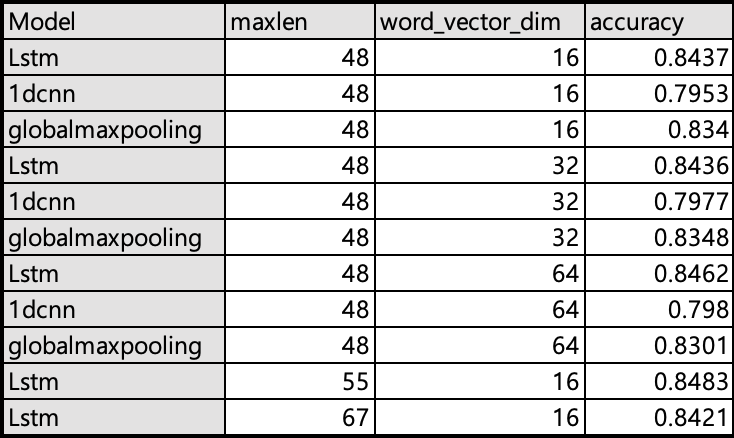
- 하지만 예시 문장을 넣고 예측했을 때는 세 모델 모두 결과 예측을 잘 했음.



토큰화과정을 살펴보니 문장의 전처리를 진행하지 않아서 제대로 되지 않았음을 확인할 수 있었다.

In [390]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
        print(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data[0:10], test_data[0:10]) 

['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리']
['흠', '.', '..', '포스터', '보고', '초딩', '영화', '줄', '.', '...', '오버', '연기', '조차', '가볍', '지', '않', '구나']
['너무', '재', '밓었다그래서보는것을추천한다']
['교도소', '이야기', '구먼', '.', '.', '솔직히', '재미', '없', '다', '.', '.', '평점', '조정']
['사이몬페그', '익살', '스런', '연기', '돋보였', '던', '영화', '!', '스파이더맨', '에서', '늙', '어', '보이', '기', '만', '했', '던', '커스틴', '던스트', '너무나', '이뻐', '보였', '다']
['막', '걸음마', '뗀', '3', '세', '부터', '초등', '학교', '1', '학년', '생', '인', '8', '살', '용', '영화', '.', 'ㅋㅋㅋ', '.', '..', '별반', '개', '아까움', '.']
['원작', '긴장감', '을', '제대로', '살려', '내', '지', '못했', '다', '.']
['별', '반개', '아깝', '다', '욕', '나온다', '이응경', '길용우', '연기', '생활', '몇', '년', '인지', '.', '.', '정말', '발', '로', '해도', '그것', '보단', '낫', '겟', '다', '납치', '.', '감금', '만', '반복', '반복', '.', '.', '드라마', '가족', '없', '다', '연기', '못', '하', '사람', '만', '모엿', '네']
['액션', '없', '는데', '재미', '있', '몇', '안', '되', '영화']
['왜', '케', '평점', '낮', '건데', '?', '꽤', '볼', '만한데', '.', '.', '헐리우드', '식', '화려', '함', '만', '너무', '길들여져', '있', '나', '?'

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [410]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data1(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        sentence = re.sub(r'[^가-힣 ]','', sentence)
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        sentence = re.sub(r'[^가-힣 ]','', sentence)
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train1, y_train1, X_test1, y_test1, word_to_index1 = load_data1(train_data, test_data) 

In [411]:
index_to_word = {index:word for word, index in word_to_index1.items()}

In [413]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

X_train1 = keras.preprocessing.sequence.pad_sequences(X_train1,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test1 = keras.preprocessing.sequence.pad_sequences(X_test1,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [414]:
# validation set 분리

from sklearn.model_selection import train_test_split

train_X1, val_X1, train_y1, val_y1 = train_test_split(X_train1, y_train1,
                                                  test_size=0.2,
                                                  shuffle=False, 
                                                  random_state=9082)

In [415]:
vocab_size = 10000  
word_vector_dim = 16 

model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(128))                        #  RNN에서 가장 널리 사용하는 LSTM 레이어 사용
model1.add(keras.layers.Dense(16, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1 dim 
model1.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, None, 16)          160000    
                                                                 
 lstm_20 (LSTM)              (None, 128)               74240     
                                                                 
 dense_62 (Dense)            (None, 16)                2064      
                                                                 
 dense_63 (Dense)            (None, 1)                 17        
                                                                 
Total params: 236,321
Trainable params: 236,321
Non-trainable params: 0
_________________________________________________________________


In [416]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model1a_history = model1.fit(train_X1,
                            train_y1,
                            epochs=10, 
                            batch_size = 256, 
                            validation_data = (val_X1, val_y1), 
                            verbose = 1)

Epoch 1/10
457/457 [==============================] - 6s 10ms/step - loss: 0.4504 - accuracy: 0.7866 - val_loss: 0.3697 - val_accuracy: 0.8363
Epoch 2/10
457/457 [==============================] - 4s 9ms/step - loss: 0.3446 - accuracy: 0.8503 - val_loss: 0.3659 - val_accuracy: 0.8387
Epoch 3/10
457/457 [==============================] - 4s 8ms/step - loss: 0.3256 - accuracy: 0.8610 - val_loss: 0.3636 - val_accuracy: 0.8398
Epoch 4/10
457/457 [==============================] - 4s 8ms/step - loss: 0.3105 - accuracy: 0.8683 - val_loss: 0.3581 - val_accuracy: 0.8421
Epoch 5/10
457/457 [==============================] - 4s 8ms/step - loss: 0.2917 - accuracy: 0.8758 - val_loss: 0.3617 - val_accuracy: 0.8433
Epoch 6/10
457/457 [==============================] - 4s 9ms/step - loss: 0.2702 - accuracy: 0.8847 - val_loss: 0.3609 - val_accuracy: 0.8440
Epoch 7/10
457/457 [==============================] - 4s 8ms/step - loss: 0.2482 - accuracy: 0.8945 - val_loss: 0.3763 - val_accuracy: 0.8432
Epoch

In [417]:
results1a = model1.evaluate(X_test1,  y_test1, verbose=2)

print(results1a)

1537/1537 - 4s - loss: 0.4385 - accuracy: 0.8360 - 4s/epoch - 3ms/step
[0.4384935796260834, 0.8360355496406555]


In [424]:
vocab_size = 10000  
word_vector_dim = 32 

model4 = keras.Sequential()
model4.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model4.add(keras.layers.LSTM(16))                        #  RNN에서 가장 널리 사용하는 LSTM 레이어 사용
model4.add(keras.layers.Dense(8, activation='relu'))
model4.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1 dim 
model4.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, None, 32)          320000    
                                                                 
 lstm_23 (LSTM)              (None, 16)                3136      
                                                                 
 dense_68 (Dense)            (None, 8)                 136       
                                                                 
 dense_69 (Dense)            (None, 1)                 9         
                                                                 
Total params: 323,281
Trainable params: 323,281
Non-trainable params: 0
_________________________________________________________________


In [425]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model1a_history = model4.fit(train_X1,
                            train_y1,
                            epochs=10, 
                            batch_size = 128, 
                            validation_data = (val_X1, val_y1), 
                            verbose = 1)

Epoch 1/10
914/914 [==============================] - 8s 7ms/step - loss: 0.4161 - accuracy: 0.8052 - val_loss: 0.3604 - val_accuracy: 0.8379
Epoch 2/10
914/914 [==============================] - 6s 7ms/step - loss: 0.3290 - accuracy: 0.8557 - val_loss: 0.3497 - val_accuracy: 0.8446
Epoch 3/10
914/914 [==============================] - 6s 6ms/step - loss: 0.2978 - accuracy: 0.8702 - val_loss: 0.3471 - val_accuracy: 0.8468
Epoch 4/10
914/914 [==============================] - 6s 6ms/step - loss: 0.2702 - accuracy: 0.8826 - val_loss: 0.3563 - val_accuracy: 0.8470
Epoch 5/10
914/914 [==============================] - 6s 6ms/step - loss: 0.2464 - accuracy: 0.8933 - val_loss: 0.3769 - val_accuracy: 0.8448
Epoch 6/10
914/914 [==============================] - 6s 6ms/step - loss: 0.2244 - accuracy: 0.9034 - val_loss: 0.3983 - val_accuracy: 0.8445
Epoch 7/10
914/914 [==============================] - 6s 6ms/step - loss: 0.2058 - accuracy: 0.9127 - val_loss: 0.4159 - val_accuracy: 0.8416
Epoch 

In [426]:
results1a = model4.evaluate(X_test1,  y_test1, verbose=2)

print(results1a)

1537/1537 - 5s - loss: 0.5562 - accuracy: 0.8349 - 5s/epoch - 3ms/step
[0.5561529994010925, 0.8348556756973267]


텍스트에서 학습한 임베딩을 이용해서는 딥러닝 모델과 파라미터를 조절하는 것으로는 85% 이상이 나오지 않았음. 


### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [427]:
from gensim.models import KeyedVectors

word2vec_path = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 09/ko/ko.bin' 
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [428]:
word2vec.similar_by_word("느낌")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('웃음', 0.6430885195732117),
 ('표정', 0.6235764026641846),
 ('매력', 0.6022306084632874),
 ('음색', 0.5814720988273621),
 ('기분', 0.5680215954780579),
 ('창법', 0.5630674958229065),
 ('안정감', 0.5628033876419067),
 ('선율', 0.5608673691749573),
 ('면도', 0.5582115650177002),
 ('듯하', 0.5581769943237305)]

In [429]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [447]:
#LSTM 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   #trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 48, 200)           2000000   
                                                                 
 lstm_25 (LSTM)              (None, 128)               168448    
                                                                 
 dense_71 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [448]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history = model.fit(train_X,
                    train_y,
                    epochs=10,
                    batch_size=128,
                    validation_data=(val_X, val_y),
                    verbose=1)

Epoch 1/10
914/914 [==============================] - 16s 14ms/step - loss: 0.4124 - accuracy: 0.8061 - val_loss: 0.3421 - val_accuracy: 0.8510
Epoch 2/10
914/914 [==============================] - 9s 9ms/step - loss: 0.3052 - accuracy: 0.8689 - val_loss: 0.3211 - val_accuracy: 0.8631
Epoch 3/10
914/914 [==============================] - 8s 9ms/step - loss: 0.2616 - accuracy: 0.8907 - val_loss: 0.3189 - val_accuracy: 0.8660
Epoch 4/10
914/914 [==============================] - 8s 9ms/step - loss: 0.2242 - accuracy: 0.9078 - val_loss: 0.3288 - val_accuracy: 0.8650
Epoch 5/10
914/914 [==============================] - 8s 9ms/step - loss: 0.1850 - accuracy: 0.9260 - val_loss: 0.3474 - val_accuracy: 0.8638
Epoch 6/10
914/914 [==============================] - 8s 9ms/step - loss: 0.1474 - accuracy: 0.9425 - val_loss: 0.3905 - val_accuracy: 0.8604
Epoch 7/10
914/914 [==============================] - 8s 9ms/step - loss: 0.1133 - accuracy: 0.9577 - val_loss: 0.4588 - val_accuracy: 0.8566
Epoc

In [449]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.6418 - accuracy: 0.8516 - 4s/epoch - 3ms/step
[0.6417559385299683, 0.8515979647636414]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


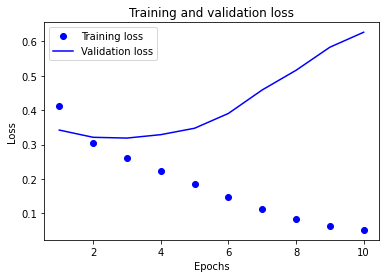

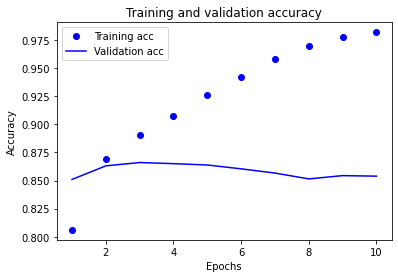

In [455]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [452]:
sentiment_predict(model,'이거 뭐지 무슨 생각으로 찍은거지...')

['이거', '뭐', '지', '무슨', '생각', '찍', '거', '지', '.', '..'] [1, 118, 85, 15, 212, 72, 267, 45, 15, 4, 11] 0.0007601470570079982
99.92% 확률로 부정 리뷰입니다.



In [453]:
sentiment_predict(model,'이거 좀 재밌네 ㅋㅋㅋ')

['이거', '재밌', '네', 'ㅋㅋㅋ'] [1, 118, 34, 43, 69] 0.9998952150344849
99.99% 확률로 긍정 리뷰입니다.



# 회고

- 이번 노드는 영화 리뷰들을 텍스트로 받아서 리뷰가 긍정인지 부정인지 판단하는 모델을 만들어 결과를 비교하는 것이었다. 구글의 힘을 빌어 세가지 모델들을 다들 썼길래 그 모델들을 가지고와서 비교해보았다. 한글의 자연어 처리는 처음이라 텍스트 전처리 과정이 정확도에 영향을 주지 않을까 생각했었는데, 생각보다 영향이 적은 듯 했다. 그것보단 임베딩이 되어있는 것을 활용하는 것이 결과에 더 큰 영향을 주는 것이 의외였다. 

- 각 모델들이 어떤 의미로 선택되었고 또 어떤 영향을 주는지 아직까진 이해가 잘 되지 않았다. 

- 구글링을 했을 때는 임베딩 레이어에 대한 분석은 있었지만 목표인 문장을 넣었을 때 긍정인지 부정인지에 대한 결과 비교는 없어서 코드로 확인하는데 생각보다 시간이 많이 들어갔다. 


### 참고

https://junstar92.tistory.com/135


https://wikidocs.net/44249


https://github.com/yenaryu/Project/blob/main/%5BE-06%5Dmovie%20reivew%20sentiment.ipynb